In [121]:
from zerosum.pkr.game import RiverOfBlood, Call, Check
from zerosum.algorithms.algo import Runner
from zerosum.pkr.abstraction.hands import emd
from blood.spes40 import Abstraction

In [100]:
from blood.basic import _equity_abstraction
import pickle


street = 5
d = 50


path = f"centroids/{street}-40-{d}.pkl"
with open(path, "rb") as f:
    centroids = pickle.load(f)

pot = _equity_abstraction(street, centroids, d, 1000)

In [101]:
def atstreet(street: int, strategy):
    g = RiverOfBlood()

    while g._street < street:
        if g.terminal:
            return atstreet(street, strategy)

        if g.chance:
            g = g.apply(g.sample())
            continue
        
        iset = g.infoset(g.active)
        if iset not in strategy:
            action = Check() if Check() in iset.actions() else Call()
        else:
            s = strategy[iset]
            action = max(s, key=s.__getitem__)

        g = g.apply(action)

    return g


def onestreet(g, strategy):
    street = g._street + 1

    while g._street < street and not g.terminal:
        if g.chance:
            g = g.apply(g.sample())
            continue

        iset = g.infoset(g.active)
        if iset not in strategy:
            action = Check() if Check() in iset.actions() else Call()
        else:
            s = strategy[iset]
            action = max(s, key=s.__getitem__)

        g = g.apply(action)

    return g

In [102]:
import numpy as np


def potential(g, strategy, pot, d, maxiter):
    root = g

    pots = []
    while maxiter > 0:
        g = onestreet(root, strategy)
        if g.terminal:
            continue

        pots.append(pot(g.infoset(g.active)))
        maxiter -= 1

    h, _ = np.histogram(pots, bins=d, range=(0, d))
    return h / h.sum()

In [103]:
runner = Runner.load("bloods/spes40.pkl", Abstraction, 0, None)
strategy = runner.impl.strategies

In [170]:
from tqdm import tqdm

potentials = []
for _ in tqdm(range(1000)):
    g = atstreet(street - 1, strategy)
    if g.terminal:
        continue

    h = potential(g, strategy, pot, len(centroids), 100)
    potentials.append(h)

100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]


<BarContainer object of 40 artists>

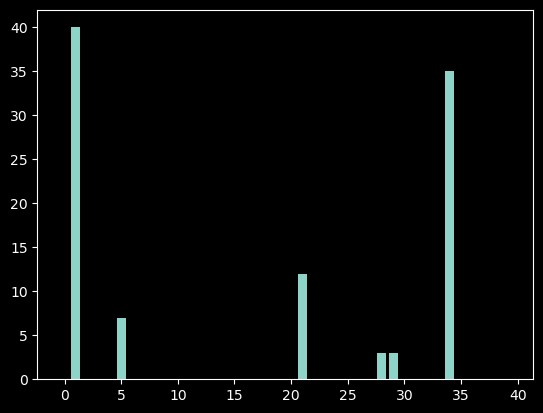

In [171]:
import matplotlib.pyplot as plt
import random


rd = random.randint(0, len(potentials) - 1)
plt.bar(range(len(centroids)), potentials[rd])

In [172]:
dists = np.zeros((len(centroids), len(centroids)))
for i in range(len(centroids)):
    for j in range(i + 1, len(centroids)):
        dists[i, j] = dists[j, i] = emd(centroids[i], centroids[j])

In [173]:
sorteddists = np.argsort(dists, axis=1)

In [174]:
from numba import njit


@njit
def emd2(p1, p2):
    p2 = list(p2)

    cost = 0
    for i, v in enumerate(p1):
        for j in sorteddists[i]:
            if p2[j] > 0:
                moved = min(p2[j], v)
                v -= moved
                p2[j] -= moved
                cost += moved * dists[i, j]

            if v == 0:
                continue
    
    return cost

In [175]:
%%timeit

rd1 = random.randint(0, len(potentials) - 1)
rd2 = random.randint(0, len(potentials) - 1)
dis = emd2(potentials[rd1], potentials[rd2])

7.32 µs ± 369 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


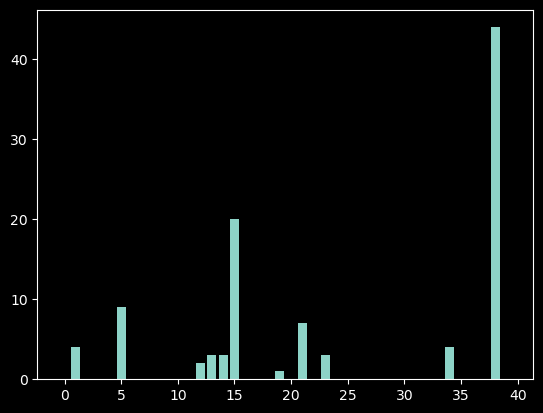

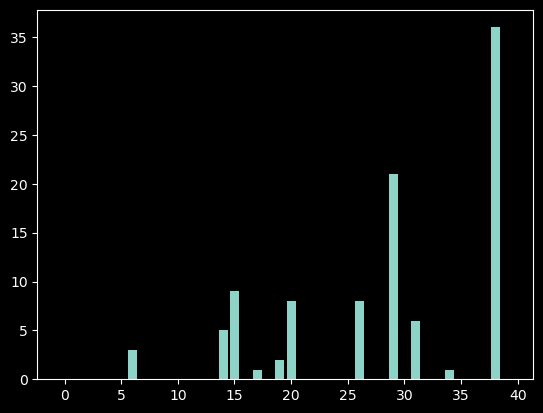

In [176]:
import math


rd = random.randint(0, len(potentials) - 1)
h = potentials[rd]

mi, md = 0, math.inf
for i, po in enumerate(potentials):
    if i != rd:
        dis = emd2(h, po)

        if dis < md:
            md = dis
            mi = i

plt.bar(range(len(centroids)), h)
plt.show()
plt.bar(range(len(centroids)), potentials[mi])
plt.show()

In [177]:
from zerosum.pkr.abstraction.kmeans import kmeans, kmeanspp

In [178]:
vecs = np.asarray(potentials)

cs = kmeanspp(vecs, 10, emd2)
cs, _ = kmeans(vecs, cs, 1000, emd2)

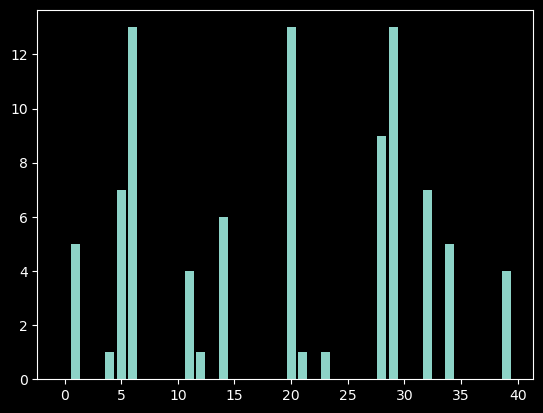

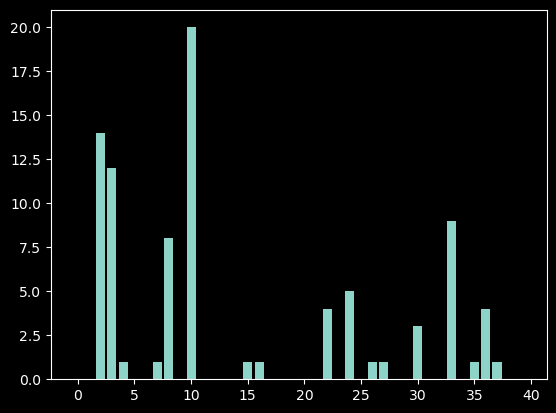

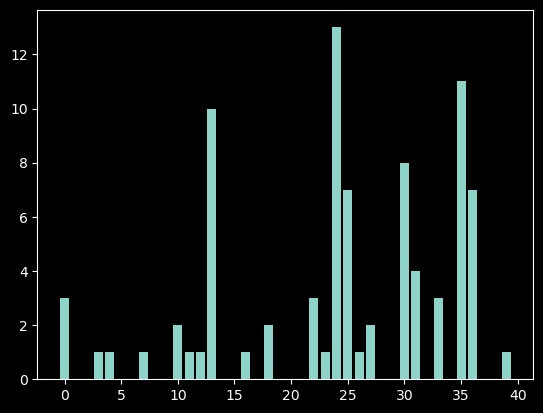

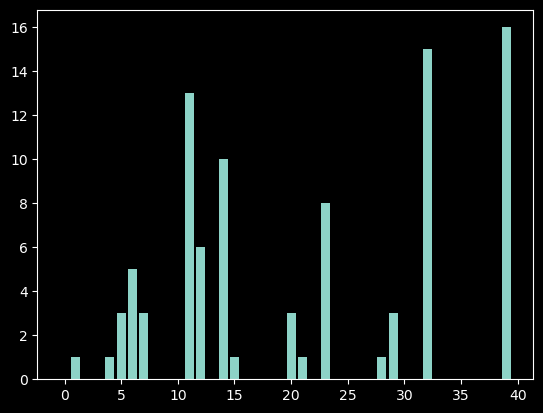

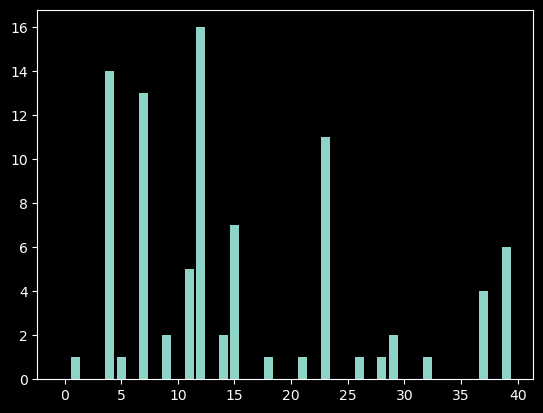

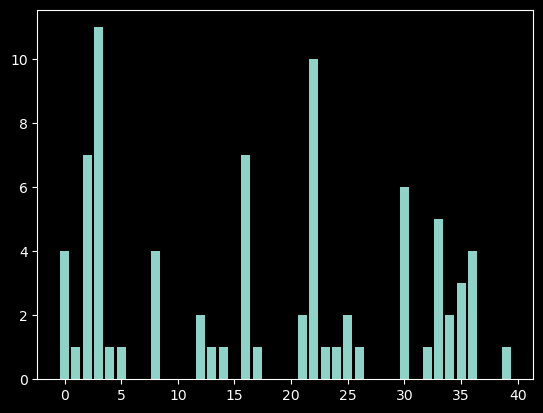

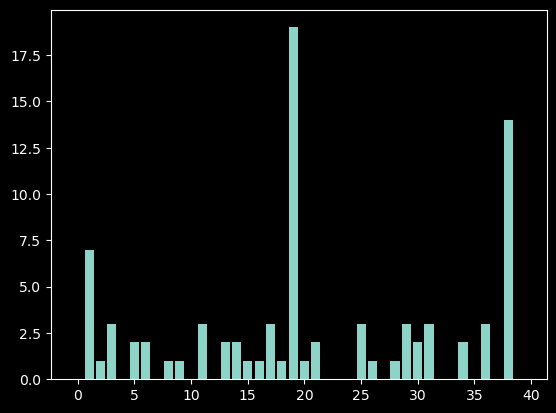

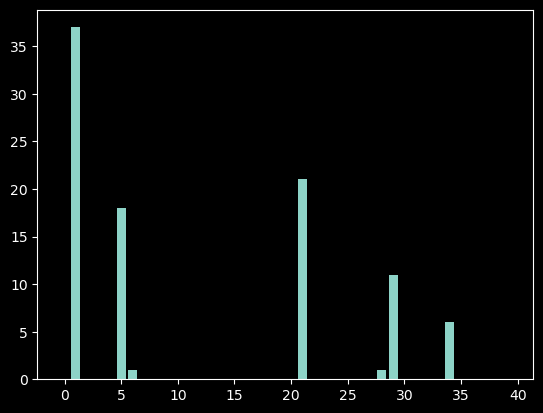

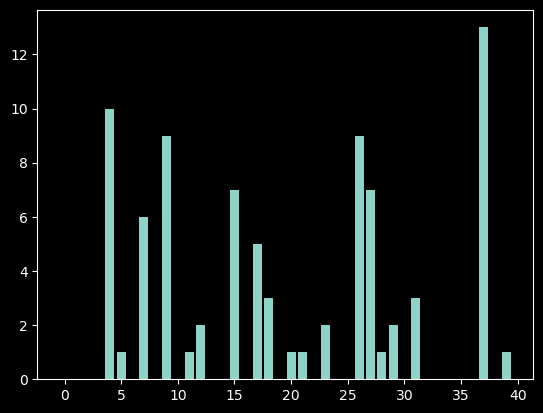

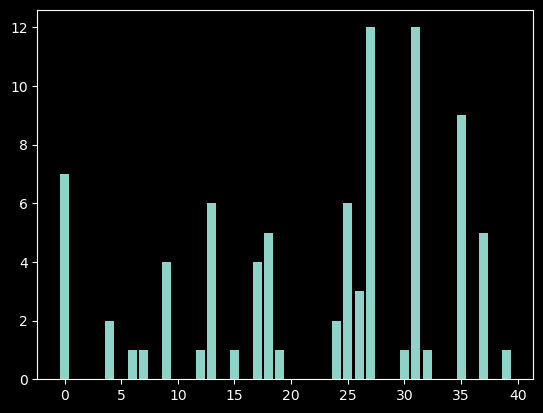

In [193]:
for c in cs:
    plt.bar(range(len(centroids)), c)
    plt.show()